This notebook contains code to do make prediction on single image and to do batch prediction. The code are only for inference and not for testing performance of the model 

### Importing required packages

In [193]:
import warnings
warnings.filterwarnings('ignore')
import torch
from fastai.vision.all import *
from fastai.vision import widgets 
import matplotlib.pyplot as plt
from pathlib import Path


from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    Flip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

In [3]:
# Class for data augmentation
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    
transformPipeline=Compose([
                        Flip(p=0.5),
                        Transpose(p=0.5),
                        Rotate(p=0.40,limit=10)
                    ],p=1)

In [4]:
def label_func(fn): return path/"masks"/f"{fn.stem}{fn.suffix}"


### Loading Saved Model

In [194]:
model_path = Path("./models/restnet101_final.pkl")
learn_inf = load_learner(model_path,cpu=False)


### Simple UI to upload image and perform segmentation

In [198]:
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()
btn_run = widgets.Button(description='Segment')


def on_click_segmentation(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
#     with out_pl: display(img.to_thumb(156,156))
    pred= learn_inf.predict(img)
#     pred[0].show(figsize=(3,3))
    
    plt.figure()
    
    plt.subplot(1,2,1)
    plt.title("Original Image")
    plt.imshow(img, 'gray', interpolation='none')
    plt.subplot(1,2,2)
    plt.title("Overlayed Image")

    plt.imshow(img, 'gray', interpolation='none')
    plt.imshow(pred[0], 'jet', interpolation='none', alpha=0.3)
    plt.show()

In [199]:
btn_run.on_click(on_click_segmentation)

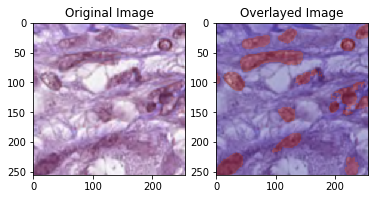

In [200]:
widgets.VBox([widgets.Label('Select Image!'),btn_upload, btn_run, out_pl, lbl_pred])

### Batch Inference

In [201]:
path = "./data/sample_test"

In [202]:
imgs = get_image_files(path)
imgs


(#5) [Path('data/sample_test/02658.png'),Path('data/sample_test/02669.png'),Path('data/sample_test/02657.png'),Path('data/sample_test/02659.png'),Path('data/sample_test/02710.png')]

#### Removing Corrupt Images

In [203]:
failed = verify_images(imgs)
failed

(#0) []

In [204]:
dl_test = learn_inf.dls.test_dl(imgs)

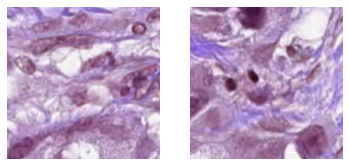

In [205]:
dl_test.show_batch()

In [206]:
dl_test.items[1].stem

'02669'

In [207]:
def show_batch(dl,preds,n):
    imgs = [PILImage.create(img) for img in dl.items]
    
    fig=plt.figure(figsize=(12,12))
    fig.suptitle('Original/Overlayed')
    
    for i in range(2*n):
        ax=fig.add_subplot(n,2,i+1)
        if i%2 == 0:
            ax.imshow(imgs[i//2])
        
        else:
            ax.imshow(imgs[(i-1)//2],'gray')
            ax.imshow(preds[(i-1)//2],'jet', alpha=0.3)
           

In [214]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


In [217]:
def batch_inference(dl,learn,show_image=2,save_csv=True):
    """Make batch inference and save result"""
    _,_,preds = learn.get_preds(dl=dl,with_decoded=True)
    
    show_batch(dl,preds,show_image)
    
    if save_csv:
        imgs = [img.stem for img in dl.items]
    
        fname = "./results/" + model_path.stem + ".csv"
        
        print(f"Saving results to {fname}")

        with open(fname, 'w') as f:
            f.write('img,rle_mask\n')
            for index, i in enumerate(imgs):
                enc = rle_encode(preds[index])
                f.write('{},{}\n'.format(i, enc))
        
               



Saving results to ./results/restnet101_final.csv


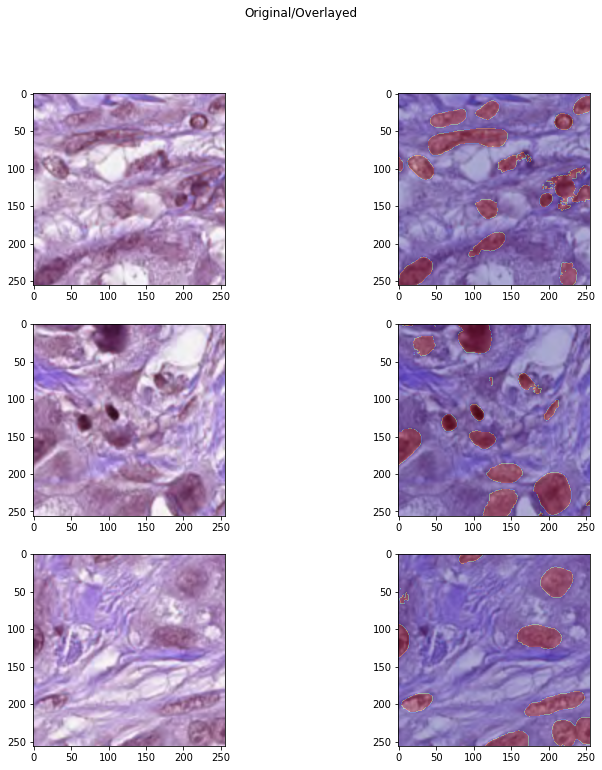

In [218]:
batch_inference(dl_test,learn_inf,show_image=3)